Price at (x=100, y=100, z=100) = 9437.8826


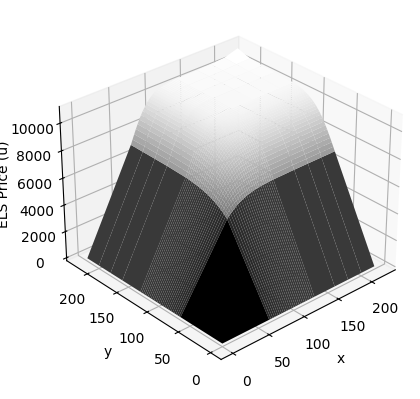

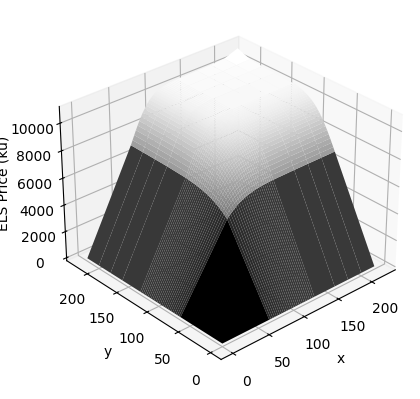

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Thomas Algorithm
def thomas(alpha, beta, gamma, f):
    """
    Simple tridiagonal matrix solver (Thomas Algorithm).
    alpha, beta, gamma: lower, main, upper diagonal respectively (length n)
    f: right-hand side vector (length n)
    """
    n = len(f)
    v = np.zeros(n, dtype=float)

    # copy
    a = alpha.copy()
    b = beta.copy()
    c = gamma.copy()
    r = f.copy()

    # forward elimination
    for i in range(1, n):
        mult = a[i] / b[i-1]
        b[i] -= mult * c[i-1]
        r[i] -= mult * r[i-1]

    # back substitution
    v[n-1] = r[n-1] / b[n-1]
    for i in range(n-2, -1, -1):
        v[i] = (r[i] - c[i]*v[i+1]) / b[i]

    return v

# =========================
# Initial Parameter Setup
# =========================
facevalue = 10000
x_volatility = 0.2662
y_volatility = 0.2105
z_volatility = 0.2111
rho_xy = 0.279
rho_yz = 0.5256
rho_xz = 0.2895

r = 0.0165
T = 3
Nt = 180 * T  # 540
dt = T / Nt

x0 = 100
y0 = 100
z0 = 100

# Define x, y, z for non-uniform grid
A = np.array([0])
B = np.arange(65, 132.5, 2.5)
C = np.array([160, 180, 200, 220])
x = np.r_[A, B, C]  # length Nx
y = x              # length Ny
z = x              # length Nz

Nx = len(x)
Ny = len(y)
Nz = len(z)

hx = np.diff(x)  # length Nx-1
hy = np.diff(y)  # length Ny-1
hz = np.diff(z)  # length Nz-1

# Coupon/Strike Price
coupon_rate = np.array([0.28, 0.24, 0.192, 0.144, 0.096, 0.048])  # 6 early redemptions
strike_price = np.array([0.85, 0.85, 0.90, 0.90, 0.95, 0.95])     # 6 periods
# Early redemption points (6 times)
step = (np.arange(1, 7) * Nt / 6).astype(int)  # [Nt/6, 2Nt/6, ..., 6Nt/6] → converted to int

dummy = 0.06  # If any underlying asset < strike_price[0] in the first period, dummy coupon
kib = 0.50    # Knock-In Barrier

# Initialize 3D arrays u, ku
u = np.zeros((Nx, Ny, Nz))
ku = np.zeros((Nx, Ny, Nz))

# =========================
# Initial Conditions (Maturity/Barrier State) Setup
# =========================
for i in range(Nx):
    for j in range(Ny):
        for k in range(Nz):
            # If any asset falls below KIB, immediate principal loss
            if (x[i] <= kib*x0 or y[j] <= kib*y0 or z[k] <= kib*z0):
                payoff = np.min([x[i], y[j], z[k]])/x0 * facevalue
                u[i,j,k] = payoff
                ku[i,j,k] = payoff
            # If any underlying asset < strike_price[0] in the first period -> facevalue*(1 + dummy)
            elif (x[i] < strike_price[0]*x0 or
                  y[j] < strike_price[0]*y0 or
                  z[k] < strike_price[0]*z0):
                u[i,j,k]  = facevalue*(1 + dummy)
                ku[i,j,k] = np.min([x[i], y[j], z[k]])/x0 * facevalue
            else:
                # All above barrier & strike, apply first coupon
                u[i,j,k]  = facevalue*(1 + coupon_rate[0])
                ku[i,j,k] = facevalue*(1 + coupon_rate[0])

# =========================
# Coefficient (Tridiagonal) Setup
# =========================
ax = np.zeros(Nx-2); dx = np.zeros(Nx-2); cx = np.zeros(Nx-2)
ay = np.zeros(Ny-2); dy = np.zeros(Ny-2); cy = np.zeros(Ny-2)
az = np.zeros(Nz-2); dz = np.zeros(Nz-2); cz = np.zeros(Nz-2)

# x-coefficients (x[1..Nx-2])
ax[:] = (-(x_volatility*x[1:Nx-1])**2 + r*x[1:Nx-1]*hx[1:Nx-1]) / (
         hx[0:Nx-2]*(hx[0:Nx-2] + hx[1:Nx-1]) )

dx[:] = ( 1/dt
        + (x_volatility*x[1:Nx-1])**2 / (hx[0:Nx-2]*hx[1:Nx-1])
        - r*x[1:Nx-1]*(hx[1:Nx-1] - hx[0:Nx-2])/(hx[0:Nx-2]*hx[1:Nx-1])
        + r/3 )

cx[:] = - ( (x_volatility*x[1:Nx-1])**2
          + r*x[1:Nx-1]*hx[0:Nx-2]) / (
          hx[1:Nx-1]*(hx[0:Nx-2]+hx[1:Nx-1]) )

# Boundary correction
ax[Nx-3] -= cx[Nx-3]
dx[Nx-3] += 2*cx[Nx-3]

# y-coefficients (Note: use y[1:Ny-1], corrected Nx→Ny)
ay[:] = (-(y_volatility*y[1:Ny-1])**2 + r*y[1:Ny-1]*hy[1:Ny-1]) / (
         hy[0:Ny-2]*(hy[0:Ny-2] + hy[1:Ny-1]) )

dy[:] = ( 1/dt
        + (y_volatility*y[1:Ny-1])**2 / (hy[0:Ny-2]*hy[1:Ny-1])
        - r*y[1:Ny-1]*(hy[1:Ny-1]-hy[0:Ny-2])/(hy[0:Ny-2]*hy[1:Ny-1])
        + r/3 )

cy[:] = - ( (y_volatility*y[1:Ny-1])**2
          + r*y[1:Ny-1]*hy[0:Ny-2]) / (
          hy[1:Ny-1]*(hy[0:Ny-2]+hy[1:Ny-1]) )

ay[Ny-3] -= cy[Ny-3]
dy[Ny-3] += 2*cy[Ny-3]

# z-coefficients (Note: Nz)
az[:] = (-(z_volatility*z[1:Nz-1])**2 + r*z[1:Nz-1]*hz[1:Nz-1]) / (
         hz[0:Nz-2]*(hz[0:Nz-2] + hz[1:Nz-1]) )

dz[:] = ( 1/dt
        + (z_volatility*z[1:Nz-1])**2 / (hz[0:Nz-2]*hz[1:Nz-1])
        - r*z[1:Nz-1]*(hz[1:Nz-1]-hz[0:Nz-2])/(hz[0:Nz-2]*hz[1:Nz-1])
        + r/3 )

cz[:] = - ( (z_volatility*z[1:Nz-1])**2
          + r*z[1:Nz-1]*hz[0:Nz-2]) / (
          hz[1:Nz-1]*(hz[0:Nz-2]+hz[1:Nz-1]) )

az[Nz-3] -= cz[Nz-3]
dz[Nz-3] += 2*cz[Nz-3]

# Auxiliary arrays
old_u  = np.zeros((Nx, Ny, Nz))
old_ku = np.zeros((Nx, Ny, Nz))
fx = np.zeros(Nx-2)
fy = np.zeros(Ny-2)
fz = np.zeros(Nz-2)

tag = 0  # Early redemption period index

# =========================
# Time Loop (ADI Form)
# =========================
for iter_t in range(Nt):

    # --------------------
    # 0) Update Coupon/Knock-In Conditions
    # --------------------
    # Check early redemption timing
    if tag < len(step) and (iter_t == step[tag]):
        # Apply strike_price[tag+1], coupon_rate[tag+1]
        # (Check if tag+1 is within range)
        gx = np.min(np.where(x >= x0*strike_price[tag]))
        gy = np.min(np.where(y >= y0*strike_price[tag]))
        gz = np.min(np.where(z >= z0*strike_price[tag]))

        u[gx:Nx, gy:Ny, gz:Nz]  = facevalue*(1 + coupon_rate[tag])
        ku[gx:Nx, gy:Ny, gz:Nz] = facevalue*(1 + coupon_rate[tag])

        # Synchronize with ku below KIB
        kx = np.min(np.where(x >= x0*kib))
        ky = np.min(np.where(y >= y0*kib))
        kz = np.min(np.where(z >= z0*kib))
        u[0:kx+1, :, :] = ku[0:kx+1, :, :]
        u[:, 0:ky+1, :] = ku[:, 0:ky+1, :]
        u[:, :, 0:kz+1] = ku[:, :, 0:kz+1]

        tag += 1

    # ------------------------------------------------
    # 1) X-Sweep (u, old_u)
    #    Construct fx at j=1..Ny-2, k=1..Nz-2 → thomas
    # ------------------------------------------------
    old_u[:] = u[:]  # Copy previous values (maintain original code structure)
    for j in range(1, Ny-1):
        for k in range(1, Nz-1):
            # Calculate fx (includes correlation terms)
            # 1/3 assumes user-defined cross-term splitting
            fx[:] = ( 1/3*rho_xy*x_volatility*y_volatility
                        * x[1:Nx-1] * y[j]
                        * (old_u[2:Nx,   j+1, k] - old_u[2:Nx,   j-1, k]
                         - old_u[0:Nx-2, j+1, k] + old_u[0:Nx-2, j-1, k])
                        / (hx[0:Nx-2]*hy[j] + hx[1:Nx-1]*hy[j]
                         + hx[1:Nx-1]*hy[j-1] + hx[0:Nx-2]*hy[j-1])
                     + 1/3*rho_xz*x_volatility*z_volatility
                        * x[1:Nx-1] * z[k]
                        * (old_u[2:Nx,   j, k+1] - old_u[2:Nx,   j, k-1]
                         - old_u[0:Nx-2, j, k+1] + old_u[0:Nx-2, j, k-1])
                        / (hx[0:Nx-2]*hz[k] + hx[1:Nx-1]*hz[k]
                         + hx[1:Nx-1]*hz[k-1] + hx[0:Nx-2]*hz[k-1])
                     + 1/3*rho_yz*y_volatility*z_volatility
                        * y[j]*z[k]
                        * (old_u[1:Nx-1, j+1, k+1] - old_u[1:Nx-1, j+1, k-1]
                         - old_u[1:Nx-1, j-1, k+1] + old_u[1:Nx-1, j-1, k-1])
                        / (hy[j-1]*hz[k] + hy[j]*hz[k]
                         + hy[j]*hz[k-1] + hy[j-1]*hz[k-1])
                     + old_u[1:Nx-1, j, k]/dt )

            # Solve tridiagonal system
            u[1:Nx-1, j, k] = thomas(ax, dx, cx, fx)

    # Boundary correction (3D extrapolation)
    # Extrapolate last node in x-direction (Nx-1) using 2x-difference
    u[Nx-1, 1:Ny-1, 1:Nz-1] = 2*u[Nx-2, 1:Ny-1, 1:Nz-1] - u[Nx-3, 1:Ny-1, 1:Nz-1]
    # y-direction
    u[1:Nx-1, Ny-1, 1:Nz-1] = 2*u[1:Nx-1, Ny-2, 1:Nz-1] - u[1:Nx-1, Ny-3, 1:Nz-1]
    # z-direction
    u[1:Nx-1, 1:Ny-1, Nz-1] = 2*u[1:Nx-1, 1:Ny-1, Nz-2] - u[1:Nx-1, 1:Ny-1, Nz-3]

    # ------------------------------------------------
    # 2) Y-Sweep (u, old_u)
    # ------------------------------------------------
    old_u[:] = u[:]
    for k in range(1, Nz-1):
        for i in range(1, Nx-1):
            fy[:] = ( 1/3*rho_xy*x_volatility*y_volatility
                        * x[i]*y[1:Ny-1]
                        * (old_u[i+1, 2:Ny,   k] - old_u[i+1, 0:Ny-2, k]
                         - old_u[i-1, 2:Ny,   k] + old_u[i-1, 0:Ny-2, k])
                        / (hx[i-1]*hy[1:Ny-1] + hx[i]*hy[1:Ny-1]
                         + hx[i]*hy[0:Ny-2]   + hx[i-1]*hy[0:Ny-2])
                     + 1/3*rho_xz*x_volatility*z_volatility
                        * x[i]*z[k]
                        * (old_u[i+1, 1:Ny-1, k+1] - old_u[i+1, 1:Ny-1, k-1]
                         - old_u[i-1, 1:Ny-1, k+1] + old_u[i-1, 1:Ny-1, k-1])
                        / (hx[i-1]*hz[k] + hx[i]*hz[k]
                         + hx[i]*hz[k-1] + hx[i-1]*hz[k-1])
                     + 1/3*rho_yz*y_volatility*z_volatility
                        * y[1:Ny-1]*z[k]
                        * (old_u[i, 2:Ny, k+1] - old_u[i, 2:Ny, k-1]
                         - old_u[i, 0:Ny-2, k+1] + old_u[i, 0:Ny-2, k-1])
                        / (hy[0:Ny-2]*hz[k] + hy[1:Ny-1]*hz[k]
                         + hy[1:Ny-1]*hz[k-1] + hy[0:Ny-2]*hz[k-1])
                     + old_u[i, 1:Ny-1, k]/dt )

            u[i, 1:Ny-1, k] = thomas(ay, dy, cy, fy)

    # Boundary correction
    u[1:Nx-1, Ny-1, 1:Nz-1] = 2*u[1:Nx-1, Ny-2, 1:Nz-1] - u[1:Nx-1, Ny-3, 1:Nz-1]
    u[Nx-1, 1:Ny-1, 1:Nz-1] = 2*u[Nx-2, 1:Ny-1, 1:Nz-1] - u[Nx-3, 1:Ny-1, 1:Nz-1]
    u[1:Nx-1, 1:Ny-1, Nz-1] = 2*u[1:Nx-1, 1:Ny-1, Nz-2] - u[1:Nx-1, 1:Ny-1, Nz-3]

    # ------------------------------------------------
    # 3) Z-Sweep (u, old_u)
    # ------------------------------------------------
    old_u[:] = u[:]
    for j in range(1, Ny-1):
        for i in range(1, Nx-1):
            fz[:] = ( 1/3*rho_xy*x_volatility*y_volatility
                        * x[i]*y[j]
                        * (old_u[i+1, j+1, 1:Nz-1] - old_u[i+1, j-1, 1:Nz-1]
                         - old_u[i-1, j+1, 1:Nz-1] + old_u[i-1, j-1, 1:Nz-1])
                        / (hx[i-1]*hy[j] + hx[i]*hy[j]
                         + hx[i]*hy[j-1] + hx[i-1]*hy[j-1])
                     + 1/3*rho_xz*x_volatility*z_volatility
                        * x[i]*z[1:Nz-1]
                        * (old_u[i+1, j, 2:Nz] - old_u[i+1, j, 0:Nz-2]
                         - old_u[i-1, j, 2:Nz] + old_u[i-1, j, 0:Nz-2])
                        / (hx[i-1]*hz[1:Nz-1] + hx[i]*hz[1:Nz-1]
                         + hx[i]*hz[0:Nz-2]   + hx[i-1]*hz[0:Nz-2])
                     + 1/3*rho_yz*y_volatility*z_volatility
                        * y[j]*z[1:Nz-1]
                        * (old_u[i, j+1, 2:Nz] - old_u[i, j+1, 0:Nz-2]
                         - old_u[i, j-1, 2:Nz] + old_u[i, j-1, 0:Nz-2])
                        / (hy[j-1]*hz[1:Nz-1] + hy[j]*hz[1:Nz-1]
                         + hy[j]*hz[0:Nz-2]   + hy[j-1]*hz[0:Nz-2])
                     + old_u[i, j, 1:Nz-1]/dt )

            u[i, j, 1:Nz-1] = thomas(az, dz, cz, fz)

    # Boundary correction
    u[1:Nx-1, 1:Ny-1, Nz-1] = 2*u[1:Nx-1, 1:Ny-1, Nz-2] - u[1:Nx-1, 1:Ny-1, Nz-3]
    u[Nx-1, 1:Ny-1, 1:Nz-1] = 2*u[Nx-2, 1:Ny-1, 1:Nz-1] - u[Nx-3, 1:Ny-1, 1:Nz-1]
    u[1:Nx-1, Ny-1, 1:Nz-1] = 2*u[1:Nx-1, Ny-2, 1:Nz-1] - u[1:Nx-1, Ny-3, 1:Nz-1]

    # ================
    # Sweep ku (Knock-In State) in the Same Way
    # ================
    # X-sweep
    old_ku[:] = ku[:]
    for j in range(1, Ny-1):
        for k in range(1, Nz-1):
            fx[:] = (
                1/3*rho_xy*x_volatility*y_volatility * x[1:Nx-1]*y[j] *
                (old_ku[2:Nx, j+1, k] - old_ku[2:Nx, j-1, k]
                 - old_ku[0:Nx-2, j+1, k] + old_ku[0:Nx-2, j-1, k])
                / (hx[0:Nx-2]*hy[j] + hx[1:Nx-1]*hy[j]
                   + hx[1:Nx-1]*hy[j-1] + hx[0:Nx-2]*hy[j-1])
              + 1/3*rho_xz*x_volatility*z_volatility * x[1:Nx-1]*z[k] *
                (old_ku[2:Nx, j, k+1] - old_ku[2:Nx, j, k-1]
                 - old_ku[0:Nx-2, j, k+1] + old_ku[0:Nx-2, j, k-1])
                / (hx[0:Nx-2]*hz[k] + hx[1:Nx-1]*hz[k]
                   + hx[1:Nx-1]*hz[k-1] + hx[0:Nx-2]*hz[k-1])
              + 1/3*rho_yz*y_volatility*z_volatility * y[j]*z[k] *
                (old_ku[1:Nx-1, j+1, k+1] - old_ku[1:Nx-1, j+1, k-1]
                 - old_ku[1:Nx-1, j-1, k+1] + old_ku[1:Nx-1, j-1, k-1])
                / (hy[j-1]*hz[k] + hy[j]*hz[k]
                   + hy[j]*hz[k-1] + hy[j-1]*hz[k-1])
              + old_ku[1:Nx-1, j, k]/dt
            )
            ku[1:Nx-1, j, k] = thomas(ax, dx, cx, fx)

    ku[1:Nx-1, 1:Ny-1, Nz-1] = 2*ku[1:Nx-1, 1:Ny-1, Nz-2] - ku[1:Nx-1, 1:Ny-1, Nz-3]
    ku[Nx-1, 1:Ny-1, 1:Nz-1] = 2*ku[Nx-2, 1:Ny-1, 1:Nz-1] - ku[Nx-3, 1:Ny-1, 1:Nz-1]
    ku[1:Nx-1, Ny-1, 1:Nz-1] = 2*ku[1:Nx-1, Ny-2, 1:Nz-1] - ku[1:Nx-1, Ny-3, 1:Nz-1]

    # Y-sweep
    old_ku[:] = ku[:]
    for k in range(1, Nz-1):
        for i in range(1, Nx-1):
            fy[:] = (
                1/3*rho_xy*x_volatility*y_volatility
                * x[i]*y[1:Ny-1]
                * (old_ku[i+1, 2:Ny, k] - old_ku[i+1, 0:Ny-2, k]
                   - old_ku[i-1, 2:Ny, k] + old_ku[i-1, 0:Ny-2, k])
                / (hx[i-1]*hy[1:Ny-1] + hx[i]*hy[1:Ny-1]
                   + hx[i]*hy[0:Ny-2] + hx[i-1]*hy[0:Ny-2])
              + 1/3*rho_xz*x_volatility*z_volatility
                * x[i]*z[k]
                * (old_ku[i+1, 1:Ny-1, k+1] - old_ku[i+1, 1:Ny-1, k-1]
                   - old_ku[i-1, 1:Ny-1, k+1] + old_ku[i-1, 1:Ny-1, k-1])
                / (hx[i-1]*hz[k] + hx[i]*hz[k]
                   + hx[i]*hz[k-1] + hx[i-1]*hz[k-1])
              + 1/3*rho_yz*y_volatility*z_volatility
                * y[1:Ny-1]*z[k]
                * (old_ku[i, 2:Ny, k+1] - old_ku[i, 2:Ny, k-1]
                   - old_ku[i, 0:Ny-2, k+1] + old_ku[i, 0:Ny-2, k-1])
                / (hy[0:Ny-2]*hz[k] + hy[1:Ny-1]*hz[k]
                   + hy[1:Ny-1]*hz[k-1] + hy[0:Ny-2]*hz[k-1])
              + old_ku[i, 1:Ny-1, k]/dt
            )
            ku[i, 1:Ny-1, k] = thomas(ay, dy, cy, fy)

    ku[1:Nx-1, Ny-1, 1:Nz-1] = 2*ku[1:Nx-1, Ny-2, 1:Nz-1] - ku[1:Nx-1, Ny-3, 1:Nz-1]
    ku[Nx-1, 1:Ny-1, 1:Nz-1] = 2*ku[Nx-2, 1:Ny-1, 1:Nz-1] - ku[Nx-3, 1:Ny-1, 1:Nz-1]
    ku[1:Nx-1, 1:Ny-1, Nz-1] = 2*ku[1:Nx-1, 1:Ny-1, Nz-2] - ku[1:Nx-1, 1:Ny-1, Nz-3]

    # Z-sweep
    old_ku[:] = ku[:]
    for j in range(1, Ny-1):
        for i in range(1, Nx-1):
            fz[:] = (
                1/3*rho_xy*x_volatility*y_volatility
                * x[i]*y[j]
                * (old_ku[i+1, j+1, 1:Nz-1] - old_ku[i+1, j-1, 1:Nz-1]
                   - old_ku[i-1, j+1, 1:Nz-1] + old_ku[i-1, j-1, 1:Nz-1])
                / (hx[i-1]*hy[j] + hx[i]*hy[j]
                   + hx[i]*hy[j-1] + hx[i-1]*hy[j-1])
              + 1/3*rho_xz*x_volatility*z_volatility
                * x[i]*z[1:Nz-1]
                * (old_ku[i+1, j, 2:Nz] - old_ku[i+1, j, 0:Nz-2]
                   - old_ku[i-1, j, 2:Nz] + old_ku[i-1, j, 0:Nz-2])
                / (hx[i-1]*hz[1:Nz-1] + hx[i]*hz[1:Nz-1]
                   + hx[i]*hz[0:Nz-2] + hx[i-1]*hz[0:Nz-2])
              + 1/3*rho_yz*y_volatility*z_volatility
                * y[j]*z[1:Nz-1]
                * (old_ku[i, j+1, 2:Nz] - old_ku[i, j+1, 0:Nz-2]
                   - old_ku[i, j-1, 2:Nz] + old_ku[i, j-1, 0:Nz-2])
                / (hy[j-1]*hz[1:Nz-1] + hy[j]*hz[1:Nz-1]
                   + hy[j]*hz[0:Nz-2] + hy[j-1]*hz[0:Nz-2])
              + old_ku[i, j, 1:Nz-1]/dt
            )
            ku[i, j, 1:Nz-1] = thomas(az, dz, cz, fz)

    ku[1:Nx-1, 1:Ny-1, Nz-1] = 2*ku[1:Nx-1, 1:Ny-1, Nz-2] - ku[1:Nx-1, 1:Ny-1, Nz-3]
    ku[Nx-1, 1:Ny-1, 1:Nz-1] = 2*ku[Nx-2, 1:Ny-1, 1:Nz-1] - ku[Nx-3, 1:Ny-1, 1:Nz-1]
    ku[1:Nx-1, Ny-1, 1:Nz-1] = 2*ku[1:Nx-1, Ny-2, 1:Nz-1] - ku[1:Nx-1, Ny-3, 1:Nz-1]

# =========================
# Final Result Output and Visualization
# =========================
X, Y = np.meshgrid(x, y)
kk = np.argwhere(z == 100)
if len(kk) == 0:
    print("Warning: No point where z==100 exists.")
    kk = [0]
else:
    kk = kk[0][0]  # Index where z==100

# 3D Plot (z=100 slice)
fig1 = plt.figure()
ax3d = fig1.add_subplot(111, projection='3d')
ax3d.plot_surface(X, Y, u[:, :, kk], cmap=plt.cm.gray)
ax3d.view_init(elev=30, azim=-132)
ax3d.set_xlabel('x', fontsize=10)
ax3d.set_ylabel('y', fontsize=10)
ax3d.zaxis.set_rotate_label(False)
ax3d.set_zlabel('ELS Price (u)', rotation=90, fontsize=10)

fig2 = plt.figure()
bx3d = fig2.add_subplot(111, projection='3d')
bx3d.plot_surface(X, Y, ku[:, :, kk], cmap=plt.cm.gray)
bx3d.view_init(elev=30, azim=-132)
bx3d.set_xlabel('x', fontsize=10)
bx3d.set_ylabel('y', fontsize=10)
bx3d.zaxis.set_rotate_label(False)
bx3d.set_zlabel('ELS Price (ku)', rotation=90, fontsize=10)

# Solution at (x=100, y=100, z=100)
ii = np.where(x == 100)[0]
jj = np.where(y == 100)[0]
kkk = np.where(z == 100)[0]
if len(ii)>0 and len(jj)>0 and len(kkk)>0:
    price_100_100_100 = u[ii[0], jj[0], kkk[0]]
    print("Price at (x=100, y=100, z=100) = {:.4f}".format(price_100_100_100))
else:
    print("Point x=100, y=100, or z=100 does not exist in the grid.")

plt.show()